In [1]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS230/Project/git/cs230_project/supervised

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS230/Project/git/cs230_project/supervised


In [2]:
#@title Imports
import numpy as np
np.random.seed(0)

from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Embedding
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
import tensorflow as tf
# Configure keras backend to run on CPU
# tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt

import argparse
from datetime import datetime

from utils import *
from parameters import FLAGS
from preprocessing import review_to_indices, embedding_layer_glove

from models.biLSTM import BiLSTM
from models.cnn import CNN
from models.transformer import Transformer


Parameters:
	dev_sample_percentage: 0.05
	data_file: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/amazon_reviews_us_Electronics_v1_00.tsv
	data_file2: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/amazon_reviews_us_Kitchen_v1_00.tsv
	word2vec_file: /content/drive/MyDrive/CS230/Project/git/cs230_project/data/glove.6B.100d.txt
	min_total_votes: 5
	max_review_word_count: 200
	keep_start_of_longer_reviews: True
	batch_size: 32
	num_epochs: 50
	debug_mode: False


# Unsupervised method

In [ ]:
#@title Install some libraries

!pip install keybert
!pip install keybert[flair]
!pip install keybert[gensim]
!pip install keybert[spacy]
!pip install keybert[use]

!pip install transformers

**Explanation of the algorithm** 
Here we develop an unsupervised learning algorithm that ranks $n$ reviews of a product in terms of *helpfulness*.

The algorithm works as follows:
- it first extracts a limited number of keywords from each text in the training set
- it then appends all such keywords across different training examples and extract the main keywords from them all, and creates an array $\mathtt{keywords\_universal}$ 
- at the last stage this algorithm calculates the similarity of each test example with the set of universal keywords. 
Examples with higer similarity contains more words that are central to a review, and are deemed more helpful. 

For developing this algorithm, we have used BERT pretrained transformer model for both tasks of keyword extraction and average similarity calculation using the word embedding that BERT can provide. 

In [13]:
#@title More imports

from keybert import KeyBERT
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import csv
from tqdm import tqdm

In [5]:
#@title Redefine load data slightly for the unsupervised case

def load_data_unsupervised(file_path):
    x_text = {}
    y = {}
    keys = []
    count = 0 # only used for printing purposes at the end
    
    with open(file_path, 'r') as tsv_chunk_file:
        print("Loading data ...")
        reader = csv.reader(tsv_chunk_file, delimiter='\t')
        header = next(reader)
        
        # Convert the header list to a dictionary for easier access
        header_dict = {column: index for index, column in enumerate(header)}

        for row in reader:
            total_votes   = int(row[header_dict['total_votes']])
            
            # OBS: not actually part of the algorithm to test for this but
            #      we had to do it to limit our dataset size a bit
            if total_votes < FLAGS.min_total_votes:
                continue

            review_body   = clean_str(row[header_dict['review_body']])
            product_id    = row[header_dict['product_id']]
            helpful_votes = int(row[header_dict['helpful_votes']])
            helpfulness   = helpful_votes/total_votes

            if product_id not in keys:
                keys.append(product_id)
                x_text[product_id] = []
                y[product_id] = []

            x_text[product_id].append(review_body)
            y[product_id].append(helpfulness)
            count += 1
            
        unique_ids = len(x_text)
        print(f'Data loaded. Found {count} data points from {unique_ids} unique products')
                
    return x_text, y

In [6]:
X, Y = load_data_unsupervised(FLAGS.data_file)

Loading data ...
Data loaded. Found 291203 data points from 52379 unique products


In [7]:
#@title Define keyword_extraction()

def keyword_extraction (text):
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text)
    extraction = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1),
                                           stop_words=None)
    keywords = [keyword[0] for keyword in extraction]

    return (keywords)

In [ ]:
#@title Calculate keywords

# prod_id: ['keyword_1', ..., 'keyword_n']
universal_keywords = {}
count = 0

with tqdm(total=len(X)) as pbar:
    # Loop over all product ids
    for prod_id, reviews in X.items():

        # Find keywords for each review
        keywords = []
        for review in reviews:
            keywords += keyword_extraction(review)

        # Combine them
        keywords_combine = " ".join(str(x) for x in keywords)

        # And then finds the most relevant keywords among them all
        keywords_universal = keyword_extraction(keywords_combine)

        # Save
        universal_keywords[prod_id] = keywords_universal

        # Update progress bar
        pbar.set_description(f'reviews: {len(X[prod_id])}')
        pbar.update()
        
        # This seems to take a while, let's do 10 products for now
        count += 1
        if count == 10:
            break

The next step in our algorithm is to find the relevance of the text to the keywords that are extracted. We find this relevance from how far in term of cosine similarity the words in the text are from the keywords.

We use the embedding provided by the pretrained BERT model and measure the cosine distance the word embedding between words in the text and the ones in the keyword set.

In [10]:
#@title Calculate the cosine simularity

# Calculate the cosine simularity between any embedding of words in a document
# with words in a given set. Here, this set of words is the set of keywords
# extracted just above

from transformers import logging
logging.set_verbosity_error()
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name, truncation=True, max_length=512)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)

def average_similarity(model, tokenizer, text, keyword_set):
    # Tokenize the text and words
    text_tokens =  tokenizer.encode(text, add_special_tokens=True)
    word_tokens = [tokenizer.encode(word, add_special_tokens=True)[1:-1] \
                       for word in keyword_set]

    # Convert tokens to tensors
    text_tensor  =  torch.tensor([text_tokens])[:, :512]
    word_tensors = [torch.tensor([word]) for word in word_tokens]

    # Calculate BERT embeddings for text and words
    with torch.no_grad():
        text_outputs = model(text_tensor)
        text_embeddings = torch.mean(text_outputs.hidden_states[-2], dim=1)
    
        word_embeddings = []
        for word_tensor in word_tensors:
            word_outputs = model(word_tensor)
            word_embedding = torch.mean(word_outputs.hidden_states[-2], dim=1)
            word_embeddings.append(word_embedding)

    # Calculate cosine similarity between text and words
    similarities = cosine_similarity(text_embeddings,
                                     torch.cat(word_embeddings))

    # Calculating the average similarity measure of the entire text
    # with its keywords
    avg_similarity = np.mean(similarities.squeeze())

    return avg_similarity

In [11]:
#@title Rank reviews of a product based on the cosine simularity

X_test = {key: X[key] for key in universal_keywords.keys()}
ranks  = {}

for prod_id, reviews in X_test.items():
    helpfulness = np.zeros(len(reviews))
    for i, review in enumerate(reviews):
        helpfulness[i] = average_similarity(model, tokenizer,
                                            review, universal_keywords[prod_id])
    ranks[prod_id] = np.argsort(helpfulness)

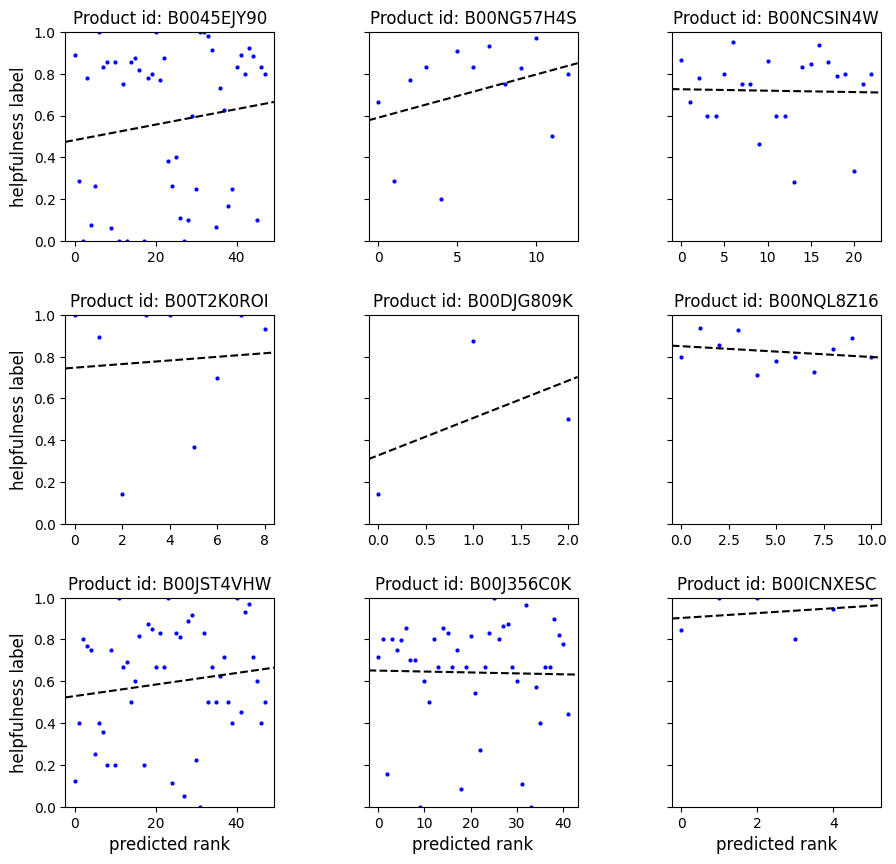

In [20]:
#@title See how this compares to customer labels

fig, axs = plt.subplots(3, 3, figsize=(10, 9), sharey=True)
for i, key in enumerate(ranks.keys()):
    if i == 9:
        break
    k = int(i / 3)
    l = i % 3

    axs[k, l].scatter(ranks[key], Y[key], s=4, c='b')

    # Fit least squares line to data and plot it
    intercept, slope = \
        np.polynomial.Polynomial.fit(ranks[key], Y[key], deg=1).convert().coef
    axs[k, l].axline((0, intercept), (1, intercept+slope),
                     color='k', linestyle='--')
    
    axs[k, l].set_title(f'Product id: {key}')
    if k == 2:
        axs[k, l].set_xlabel('predicted rank', fontsize=12)
    if l == 0:
        axs[k, l].set_ylabel('helpfulness label', fontsize=12)
    axs[k, l].set_ylim([0, 1])
    axs[k, l].set_box_aspect(1)

fig.tight_layout(pad=2.0)
plt.show()